In [4]:
# load data
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D
from keras.regularizers import l2
from keras.datasets import mnist
from keras import backend as K
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_train))
_, img_rows, img_cols = x_train.shape
print('--------------------')
print('number of classes: ', num_classes)
print('image rows, cols: ', img_rows, img_cols)
print('--------------------')
print('X_train: ', x_train.shape)
print('Y_train: ', y_train.shape)
print('X_test: ', x_test.shape)
print('Y_test: ', y_test.shape)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('--------------------')
print('X_train reshaped: ', x_train.shape)
print('X_test reshaped: ', x_test.shape)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('Y_train one-hot converted: ', y_train.shape)
print('Y_test one-hot converted: ', y_test.shape)

x_train_all = np.concatenate((x_train, x_test), axis=0)
y_train_all = np.concatenate((y_train, y_test), axis=0)
print('X_train_all: ', x_train_all.shape)
print('Y_train_all: ', x_train_all.shape)


--------------------
number of classes:  10
image rows, cols:  28 28
--------------------
X_train:  (60000, 28, 28)
Y_train:  (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
--------------------
X_train reshaped:  (60000, 28, 28, 1)
X_test reshaped:  (10000, 28, 28, 1)
Y_train one-hot converted:  (60000, 10)
Y_test one-hot converted:  (10000, 10)
X_train_all:  (70000, 28, 28, 1)
Y_train_all:  (70000, 28, 28, 1)


In [5]:
# build model
BATCH_SIZE = 128
EPOCHS = 200
LEARNING_RATE = 0.0001
L2_WEIGHT = 0.001
MODEL_PATH = 'my_model_conv.h5'

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

if os.path.isfile(MODEL_PATH):
    model.load_weights(MODEL_PATH)
    
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1638528   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total para

In [7]:
callback_reduceLearningRate = keras.callbacks.ReduceLROnPlateau(
        monitor='val_acc',
        factor=0.1,
        patience=3
    )   
callback_modelCheckpoint = keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor='acc',
        save_best_only=True
    )

callbacks_list = [
    callback_modelCheckpoint
]

# optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
optimizer = keras.optimizers.Adadelta(lr = LEARNING_RATE)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train_all, y_train_all,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 70000 samples, validate on 10000 samples
Epoch 1/200
70000/70000 [==============================] - 6s 85us/step - loss: 0.0074 - acc: 0.9978 - val_loss: 0.0029 - val_acc: 0.9994
Epoch 2/200
70000/70000 [==============================] - 6s 80us/step - loss: 0.0050 - acc: 0.9984 - val_loss: 0.0035 - val_acc: 0.9990
Epoch 3/200
70000/70000 [==============================] - 6s 80us/step - loss: 0.0038 - acc: 0.9988 - val_loss: 0.0022 - val_acc: 0.9992
Epoch 4/200
70000/70000 [==============================] - 6s 81us/step - loss: 0.0027 - acc: 0.9993 - val_loss: 0.0016 - val_acc: 0.9996
Epoch 5/200
70000/70000 [==============================] - 6s 81us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0010 - val_acc: 0.9997
Epoch 6/200
70000/70000 [==============================] - 6s 81us/step - loss: 9.5194e-04 - acc: 0.9998 - val_loss: 0.0010 - val_acc: 0.9997
Epoch 7/200
70000/70000 [==============================] - 6s 81us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 1.630

KeyboardInterrupt: 

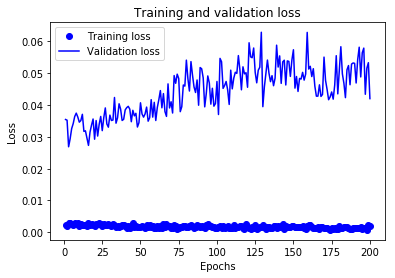

In [36]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)# model.add(Dropout(0.25))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

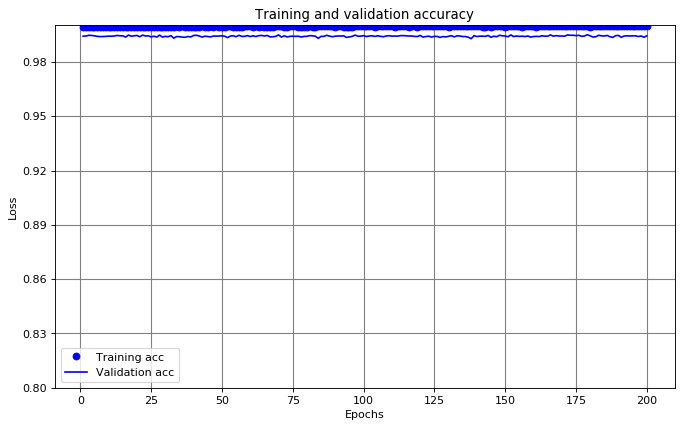

In [37]:
plt.clf()      # clear figure# clear  

from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.yticks(np.arange(0.8, 1, 0.03))
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
new_x = np.load('data/test.npy')[1:, :]
print(new_x.shape)
new_x = new_x.reshape(new_x.shape[0], 
              input_shape[0], 
              input_shape[1], 
              input_shape[2])
print(new_x.shape)

(28000, 784)
(28000, 28, 28, 1)


In [9]:
if os.path.isfile(MODEL_PATH):
    model.load_weights(MODEL_PATH)
predictions = model.predict(new_x)
print(predictions.shape)

file = open('predictions_conv.csv', 'w+')
file.write('ImageId,Label\n')
for i in range(predictions.shape[0]):
    digit = np.argmax(predictions[i])
    file.write(str(i+1) + ',' + str(digit) + '\n')

file.close()

(28000, 10)
